### Программа-классификатор спама (сообщений)

Алгоритм - Наивный байесовский классификатор

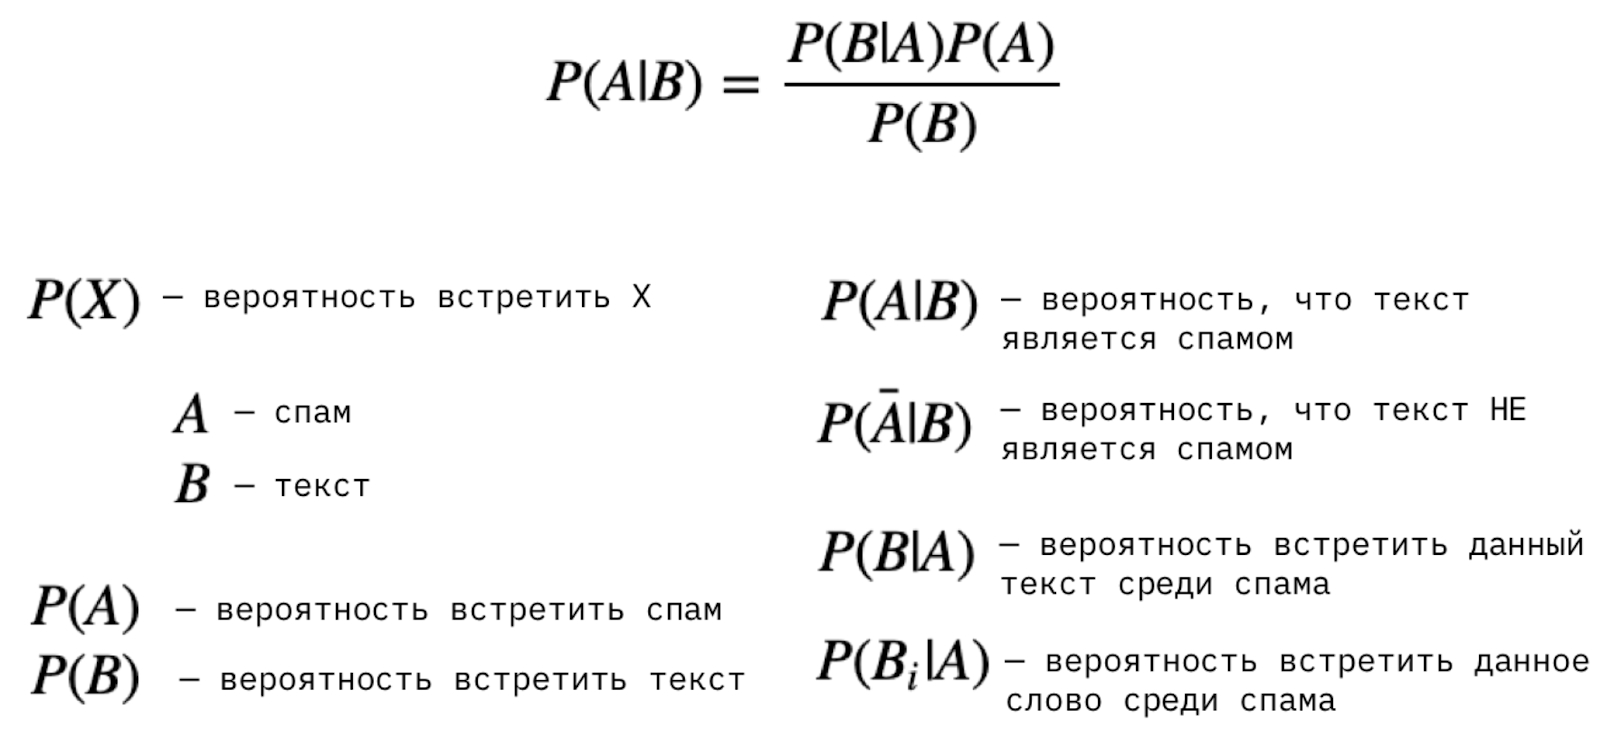

Для начала, потребуется найти pA - вероятность встретить "спомовое" сообщение во всей выборке, и pNotA(pB) - вероятность встретить полезный текст. Это сформирует представление о доле спама среди сообщений

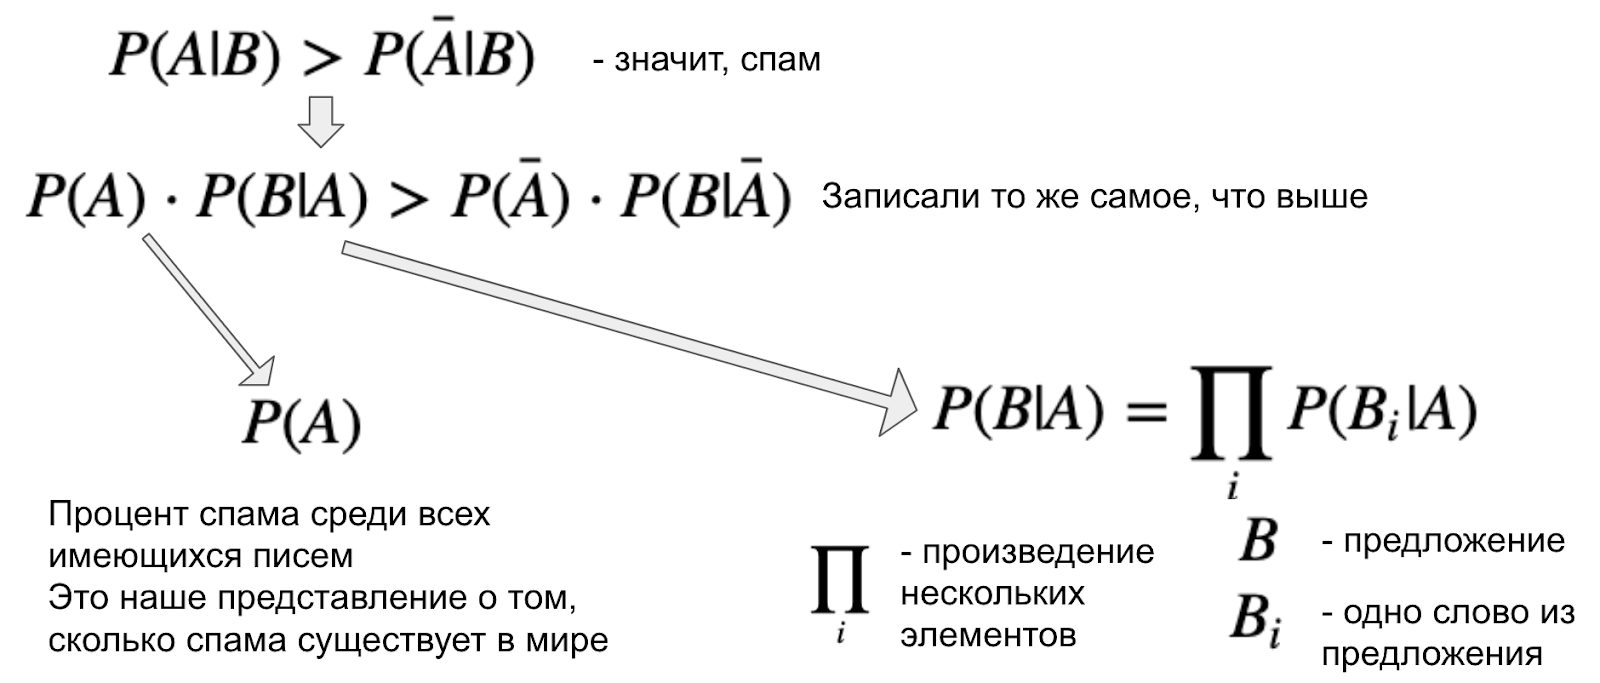

Далее, необходимо определить вероятность (p_Bi_A) встретить то или иное слово среди слов "спамовых" сообщений; аналогично - для "неспамовых" (p_Bi_notA), после чего перемножить данные вероятности между собой, получив P_B_A и P_B_notA соответственно.

Далее, перемножив pA * P_B_A и pNotA * P_B_notA - получим искомые вероятности, что текс является спамом, или полезным сообщением соответственно

In [ ]:
# Импортируем необходимые библиотеки
import re
import pandas as pd

In [ ]:
# Импортируем данные
df = pd.read_csv("../input/spam-or-not-spam-dataset/spam_or_not_spam.csv")

df['label'] = df['label'].apply(lambda l: 'spam_l' if l == 1 else 'notspam_l')
df.head(3)

In [ ]:
df.info()

In [ ]:
# Удалим пустые строки
df = df.dropna()

In [ ]:
df.info()

In [ ]:
# Определим количество сообщений в переменной
message_qty = len(df)

In [ ]:
# Очистим сообщения в датасете от лишних пробелов
def space_del(text):
    """Принимает на вход текст с лишними пробелами,
    возвращает текст с единичными пробелами"""
    s = text.strip()
    s = " ".join([el for el in s.split(' ') if el.strip()])
    return s


df['email'] = df['email'].apply(space_del)

In [ ]:
# Посмотрим на количество "спамовых" сообщений
body_spam = df[df.label == 'spam_l']
body_spam = body_spam[0:500]
spam_qty = len(body_spam)
print(spam_qty)

In [ ]:
# ...и не спамовых
body_notspam = df[df.label == 'notspam_l']
body_notspam = body_notspam[0:2500]
notspam_qty = len(body_notspam)
print(notspam_qty)

In [ ]:
# Создадим пустые словари для хранения слов
spam = {}
notspam = {}

In [ ]:
def calculate_word_frequencies(body, label):
    """Принимает на вход письмо и его метку - spam_l / notspam_l,
    подсчитывает частоту слов в текстах для справочников spam, notspam"""

    text = body.lower()
    words = re.findall(r'\b[a-z]{4,15}\b', text) # отфильтруем слова 4-15 сим
    
    if label == 'spam_l': # создадим словари "спамовых" слов      
        for word in words: 
            count = spam.get(word,0)
            spam[word] = count + 1

    else:
        for word in words:
            count = notspam.get(word,0)
            notspam[word] = count + 1

In [ ]:
def train():
    """Принимает на вход тексты, заполняет словари spam, notspam,
    считает вероятности pA, pNotA"""
    
    pA = round(spam_qty / message_qty, 2)
    pNotA = round(1 - pA, 2)
    
    for index_spam, row_spam in body_spam.iterrows():
        calculate_word_frequencies(
            row_spam['email'], row_spam['label']
        )
        
    for index_notspam, row_notspam in body_notspam.iterrows():
        calculate_word_frequencies(
            row_notspam['email'], row_notspam['label']
        )
    
    return pA, pNotA

In [ ]:
# Создадим переменные для хранения вероятностей отнесения к/не спаму
pA = train()[0]
pNotA = train()[1]

In [ ]:
print('pA:', pA, 'pNotA:', pNotA)

In [ ]:
print('спам-слова:', len(spam), 'неспам-слова:', len(notspam))

In [ ]:
# Реализуем функцию подсчета вероятности спама и неспама для слова
def calculate_P_Bi(word):
    """Принимает на вход слово,
    и считает вероятность встретить данное слово среди спама / не спама"""
    try:
        P_Bi_A = spam[word]/sum(spam.values())
    except KeyError:
        P_Bi_A = 1
    
    try:
        P_Bi_notA = notspam[word]/sum(notspam.values())
    except KeyError:
        P_Bi_notA = 1
    
    return P_Bi_A, P_Bi_notA

In [ ]:
# Проверим вероятности оказаться спамом и не спамом случайного слова
print('спам:', calculate_P_Bi('travel')[0], 
      'не спам:', calculate_P_Bi('travel')[1])

In [ ]:
# Реализуем функцию, которая будет подсчитывать вероятность спама и неспама для текста 
# Для реализации функции используется формула наивного байесовского алгоритма и функция
# для подсчета вероятности спама и неспама для слова

In [ ]:
def classify(email):
    """Принимает на вход текст,
    и считает вероятность спама / не спама для текста"""
    text = email.lower()
    words = re.findall(r'\b[a-z]{4,15}\b', text) # отфильтруем слова 4-15 сим
    P_B_A = 1
    for word in words:
        P_B_A = P_B_A * (1 + calculate_P_Bi(word)[0])
    
    P_B_notA = 1
    for word in words:
        P_B_notA = P_B_notA * (1 + calculate_P_Bi(word)[1])
    
    if P_B_A * pA < P_B_notA * pNotA:
        return 'spam_l'
    else:
        return 'notspam_l'

In [ ]:
body_spam['test'] = body_spam['email'].apply(classify)
body_notspam['test'] = body_notspam['email'].apply(classify)

In [ ]:
print(
    'точность работы классификатора для спама:', 
     body_spam.apply(lambda row: row['label'] in row['test'], axis=1).value_counts()[1]/len(body_spam))

In [ ]:
print(
    'точность работы классификатора для не спама',
    body_notspam.apply(lambda row: row['label'] in row['test'], axis=1).value_counts()[1]/len(body_notspam))

Как видно, коассификатор неплохо справился со своей задачей, точность классификации для не спама составила 92%, для спама - 100%. Протестируем работу классификатора на сообщениях не из выборки.

In [ ]:
# Письмо счастья от Уоррена Баффета:
email_1 = '''Hi, My name is Warren E. Buffett an American business magnate, 
investor and philanthropist. am the most successful investor in the world. 
I believe strongly in‘giving while living’ I had one idea that never changed in my mind? 
that you should use your wealth to help people and i have decided to give {$1,500,000.00} 
One Million Five Hundred Thousand United Dollars, to randomly selected individuals worldwide. 
On receipt of this email, you should count yourself as the lucky individual. 
Your email address was chosen online while searching at random. Kindly get back to me at 
your earliest convenience before i travel to japan for my treatment , so I know your email 
address is valid. Thank you for accepting our offer, we are indeed grateful You Can Google 
my name for more information: God bless you. Best Regard Mr.Warren E. Buffett Billionaire investor !'''

In [ ]:
classify(email_1)

In [ ]:
# Запрос обратной связи:
email_2 = '''Hi guys I want to build a website like REDACTED and I wanted to get your 
perspective of whether that site is good from the users' perspective before I go 
ahead and build something similar. I think that the design of the site is very 
modern and nice but I am not sure how people would react to a similar site? I look 
forward to your feedback. Many thanks!'''

In [ ]:
classify(email_2)

In [ ]:
# Приглашение на интервью на позицию Data Engineer:
email_3 = '''As a result of your application for the position of Data Engineer, 
I would like to invite you to attend an interview on May 30, at 9 a.m. at our 
office in Washington, DC. You will have an interview with the department manager, 
Moris Peterson. The interview will last about 45 minutes. If the date or time of 
the interview is inconvenient, please contact me by phone or email to arrange 
another appointment. We look forward to seeing you'''

In [ ]:
classify(email_3)